In [1]:
%load_ext autoreload
%autoreload 2

In [110]:
from Ge_calculation import GAP, MD_run
import matplotlib.pyplot as plt
from ase.io.cfg import read_cfg
from ase.io.extxyz import write_extxyz
from ase.neighborlist import neighbor_list
import numpy as np
import re
from sys import argv
import os
from ase import build, Atoms
from quippy.potential import Potential
from Ge_analysis import *
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from ase.neighborlist import neighbor_list
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from glob import glob
import sys

In [10]:
exp_Sq = np.genfromtxt('/Users/Moji/Documents/paper_data/Ge_Sq_exp.txt', delimiter=', ', skip_header=1)
exp_Gr = np.genfromtxt('/Users/Moji/Documents/paper_data/Ge_Gr_exp.txt', delimiter=', ', skip_header=1)

In [3]:
os.chdir('/Users/Moji/Documents/Summer20/Ge/Analysis/J04')
os.getcwd()
J04_dir = '/Users/Moji/Documents/Summer20/Ge/MD_runs/J04_parameter_explore/'

In [48]:
test = MD_run('/Users/Moji/Documents/Summer20/Ge/MD_runs/lammps_structure_test/125atom/run_64001')

In [4]:
MDs = [MD_run(i + '/run_64001', label=i) for i in glob(J04_dir + 'as*')]

In [5]:
[i.label.split('/')[-1] for i in MDs]


['as5_ds01_vF',
 'as75_ds002_vT',
 'as5_ds01_vT',
 'as75_ds002_vF',
 'as5_ds01_vF_1000atom',
 'as5_ds002_vF',
 'as5_ds002_vT',
 'as75_ds01_vT',
 'as75_ds01_vF']

In [ ]:
MDs[4].dat[3][50:120]

In [87]:
temp = MDs[4].structure_factors(rings_dir=MDs[4].label.split('/')[-1], selection=[i for i in range(70,120)], read_only=True)

In [377]:
tot = np.concatenate([i for i in MDs[4].Sq_x], axis=1)
totg = np.concatenate([i for i in MDs[4].gr], axis=1)

In [231]:
np.shape(tot)
t = np.cos(np.pi * np.linspace(0,10,100))
test = np.array([t, np.cos(t)])

In [32]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


In [366]:
def fourier(x, tau, k, theta, *a):
    ret = 0
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos(2 * deg * np.pi / tau * x + theta)
    ret *= np.exp(-k * x)
    ret += 1
    return ret

In [375]:
popt2, pcov2 = curve_fit(fourier, tot[0], tot[1], [3] + [0.4] + [0.0] + [0.0]* 12)
#popt = np.polynomial.polynomial.Polynomial.fit(tot[0], tot[1], 30).convert().coef

In [372]:
popt2


array([2.72023239, 0.81861485, 0.30367871, 4.        , 3.45258133,
       1.94182148, 1.63420896, 1.27976402, 0.95419419, 0.65152982,
       0.39332303, 0.20084739, 0.07142392])

[(0.0, 4.0), (1.0, 10.0)]

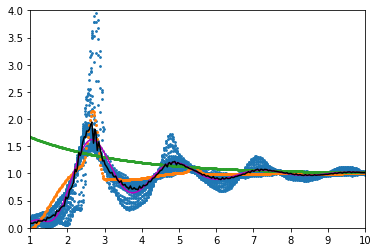

In [373]:
fig, axs = plt.subplots()
axs.scatter(tot[0], tot[1], s=3)
axs.plot(x := np.linspace(0,10,500), np.polynomial.polynomial.polyval(x, popt), color='m')
axs.plot(Sq_1000atom2[0], Sq_1000atom2[1], color='k')
axs.scatter(x, fourier(x, *popt2), s=4)
axs.scatter(t := np.linspace(0,10,500), np.exp(-0.4*t) + 1, s=3)
#axs.scatter(t, np.cos(3*t))
#axs.plot(x, fourier(x, 3, 1, 0))
axs.set(xlim=(1,10), ylim=(0,4))

[(-0.5, 4.0), (0.0, 10.0)]

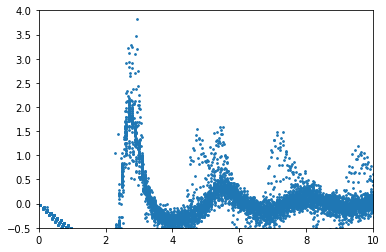

In [380]:
fig, axs = plt.subplots()
axs.scatter(totg[0], totg[1] + 1, s=3)
# axs.plot(x := np.linspace(0,10,500), np.polynomial.polynomial.polyval(x, popt), color='m')
# axs.plot(Sq_1000atom2[0], Sq_1000atom2[1], color='k')
# axs.scatter(x, fourier(x, *popt2), s=4)
# axs.scatter(t := np.linspace(0,10,500), np.exp(-0.4*t) + 1, s=3)
#axs.scatter(t, np.cos(3*t))
#axs.plot(x, fourier(x, 3, 1, 0))
axs.set(xlim=(0,10), ylim=(-.5,4))

In [107]:
tmp = np.array([tot[i][np.argsort(tot[0])] for i in range(len(tot))])
Sq_1000atom = [tmp[0], movingaverage(tmp[1], 200)]
Sq_1000atom2 = [[np.average(tmp[0][(i*50):((i+1)*50)]) for i in range(len(tot[0]//50))],
                [np.average(tmp[1][(i*50):((i+1)*50)]) for i in range(len(tot[0]//50))]]

/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/Caskroom/miniconda/base/envs/QUIP/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [103]:
np.shape(Sq_1000atom2)

(2, 35000)

In [12]:
os.chdir('/Users/Moji/Documents/Summer20/Ge/Analysis/J04')
for i in MDs:
    if 'vT' in i.label or 'vF' in i.label:
        tmp = i.structure_factors(rings_dir=i.label.split('/')[-1], selection=[155], read_only=True)

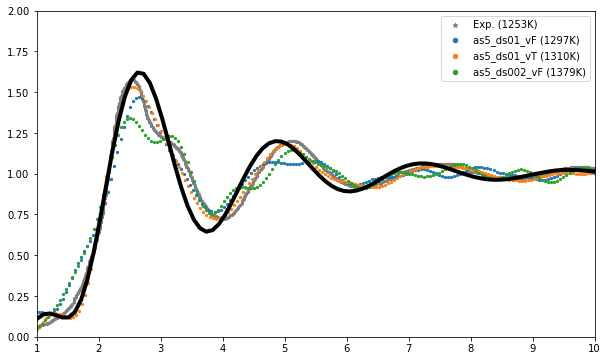

In [339]:
fig, axs = plt.subplots(figsize=(10,6))
axs.scatter(exp_Sq.T[0], exp_Sq.T[1], s=6, marker='*', label='Exp. (1253K)', color='Gray')
for i, val in enumerate([MDs[0],MDs[2], MDs[5]]):
    axs.scatter(val.Sq_x[0][0], val.Sq_x[0][1], s=5, label='{} ({}K)'.format(val.label.split('/')[-1],
                                                                             int(np.around(val.dat[3][155], decimals=0))))
#axs.plot(Sq_1000atom[0], Sq_1000atom[1], color='m', label='{} ({}K)'.format(MDs[4].label.split('/')[-1],
#                                                                         int(np.around(np.average(MDs[4].dat[3][80:120]), decimals=0))))
#axs.plot(Sq_1000atom2[0], Sq_1000atom2[1], color='c', label='{} ({}K)'.format(MDs[4].label.split('/')[-1],
#                                                                         int(np.around(np.average(MDs[4].dat[3][80:120]), decimals=0))))
axs.plot(x, np.polynomial.polynomial.polyval(x, popt), color='k', linewidth=4.0)
axs.set(xlim=(1,10), ylim=(0,2))
axs.legend(markerscale=2)

IndexError: list index out of range

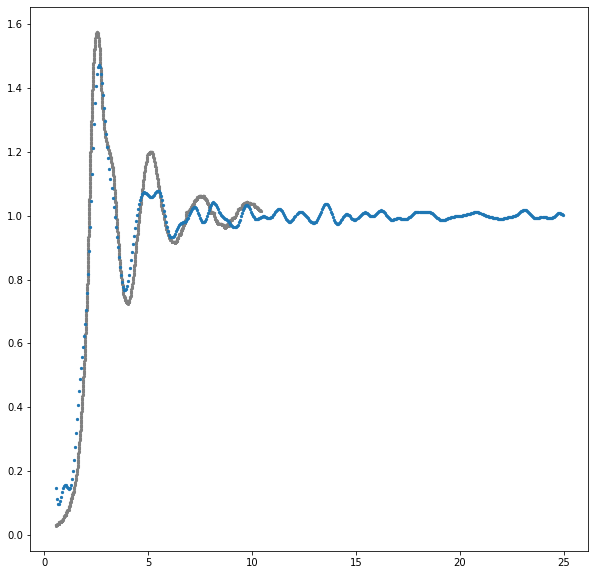

In [42]:
fig, axs = plt.subplots(figsize=(10,10))
axs.scatter(exp_Sq.T[0], exp_Sq.T[1], s=6, marker='*', label='Exp. (1253K)', color='Gray')
for i, val in enumerate([MDs[4]]):
    axs.scatter(np.concatenate([val.Sq_x[i][0] for i in range(len(val.Sq_x))]),
    np.concatenate([val.Sq_x[i][1] for i in range(len(val.Sq_x))]),
    s=5, label='{} ({}K)'.format(val.label.split('/')[-1],
    int(np.around(val.dat[3][155], decimals=0))))
axs.set(xlim=(0,11))
axs.legend(markerscale=2)


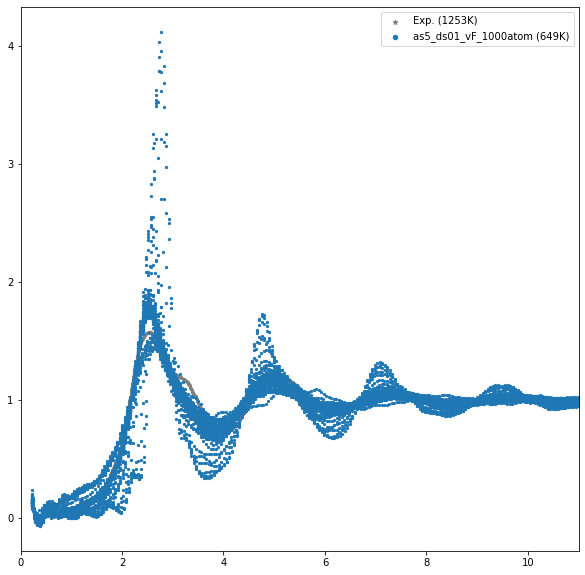

In [40]:
fig, axs = plt.subplots(figsize=(10,10))
axs.scatter(exp_Sq.T[0], exp_Sq.T[1], s=6, marker='*', label='Exp. (1253K)', color='Gray')

axs.scatter(Sq_1000atom[0], Sq_1000atom[1],
    s=5, label='{} ({}K)'.format(val.label.split('/')[-1],
    int(np.around(val.dat[3][155], decimals=0))))
axs.set(xlim=(0,11))
axs.legend(markerscale=2)

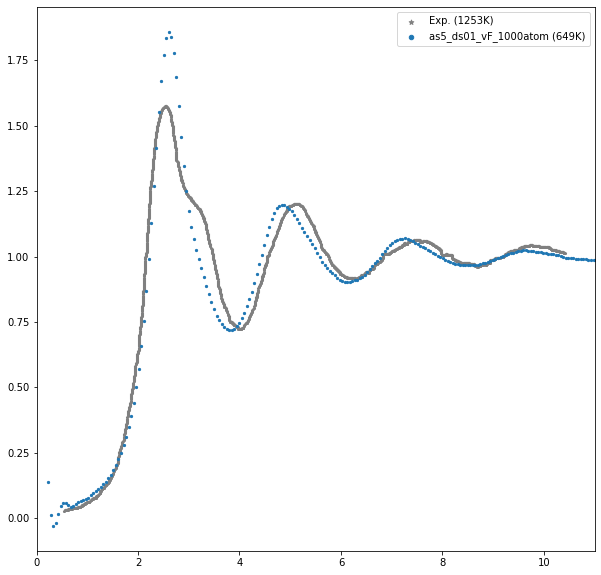

In [41]:
fig, axs = plt.subplots(figsize=(10,10))
for i, val in enumerate([MDs[0]]):
    axs.scatter(val.gr[1][0], val.gr[1][1], s=4, label='{} ({}K)'.format(val.label.split('/')[-1],
                                                                             int(np.around(val.dat[3][155], decimals=0))))
axs.scatter(exp_Gr.T[0], exp_Gr.T[1], s=4, marker='*', label='Exp. (1253K)')
axs.set(xlim=(0,11))
axs.legend(markerscale=2)

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
for i, val in enumerate([MDs[0]]):
    axs.scatter(val.Sq_n[0][0], val.Sq_n[0][1], s=4, label=val.label.split('/')[-1])
axs.scatter(exp_.T[0], exp_Gr.T[1], s=4, marker='*', label='Exp. 1123K')
axs.set(xlim=(0,11))
axs.legend(markerscale=2)

In [ ]:
a = ['1','0','100', '55']
sorted(a, key=int)

In [ ]:
a = np.array([[1,2],[3,4]])
np.concatenate([a,a], axis=1)

In [ ]:
np.concatenate([val.Sq_x[i][0] for i in range(len(val.Sq_x))]),
    np.concatenate([val.Sq_x[i][1] for i in range(len(val.Sq_x))]),


In [ ]:
a = 'hi'

IndentationError: unexpected indent (<ipython-input-38-c1b81bcb4516>, line 2)

In [ ]:
a = 'hi'

In [ ]:
a = 'hi'



In [ ]:
a = 'hi'


In [ ]:
a = 'hi


In [ ]:
a = 'h


In [ ]:
a = '


In [ ]:
a = '



In [ ]:
a = '
h


In [ ]:
a = '
hi


In [ ]:
a = '
hi'


In [ ]:
a = 'hi'


In [ ]:
a = '
hi'


In [ ]:
a = 'hi'


In [ ]:
a = '
hi'


In [ ]:
a = 'hi'


In [ ]:
a = 'h'


In [ ]:
a = ''


In [ ]:
a = 


In [ ]:
a =


In [ ]:
a 


In [ ]:
a


In [ ]:
a = np.array([[1,2],[3,4]])
np.concatenate([a,a], axis=1)

In [ ]:
np.concatenate([val.Sq_x[i][0] for i in range(len(val.Sq_x))]),
    np.concatenate([val.Sq_x[i][1] for i in range(len(val.Sq_x))]),
